🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before). 

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [1]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 576.8 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 914.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.7 kB/s eta 0:00:00 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.5 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 44.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.3 kB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a63930117f210bff406246c00e2acbd1f0fce10088170bdc51f8585eb51d42ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-nm88lvw

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

/home/shohei/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2023-11-07 05:40:37.185112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 05:40:37.185154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 05:40:37.185175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been

No Bottleneck unit testing available.


/home/shohei/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (
/home/shohei/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [2]:
# from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [3]:
# # download data
# root = "."
# SimpleOxfordPetDataset.download(root)

In [54]:
# # init train, val, test sets
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

# # It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

# n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 3669


In [3]:
import glob 
from osgeo import gdal
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from tqdm import tqdm
import pandas as pd
train_files = glob.glob('/home/shohei/sentinel/train/*.nc')
val_files = glob.glob('/home/shohei/sentinel/val/*.nc')
test_files = glob.glob('/home/shohei/sentinel/test/*.nc')

TRAIN_LENGTH = len(train_files)
# TRAIN_LENGTH = 1000
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

print(TRAIN_LENGTH)
print('train image')

5319
train image


In [5]:
train_dataset2 = []
valid_dataset2 = []
test_dataset2 = []

for i,file in tqdm(enumerate(train_files)):
    if i>TRAIN_LENGTH:
        break
    base_file = file.split('.nc')[0].split('train/')[1]
    data = Dataset('/home/shohei/sentinel/train/'+base_file+'.nc')
    fp = '/home/shohei/sentinel/masks/train/'+base_file+'.tif'
    img = rasterio.open(fp)
    time_slice = 0 # 0 to 5
    B2 = np.array(data['B2'][time_slice,:,:])
    B3 = np.array(data['B3'][time_slice,:,:])
    B4 = np.array(data['B4'][time_slice,:,:])
    B8 = np.array(data['B8'][time_slice,:,:])
    B2 = (255 * (B2 / B2.max() )).astype(np.int8)
    B3 = (255 * (B3 / B3.max() )).astype(np.int8)
    B4 = (255 * (B4 / B4.max() )).astype(np.int8)
    B8 = (255 * (B8 / B8.max() )).astype(np.int8)

    extent_img = img.read(1)
    boundary_img = img.read(2)
    distance_img = img.read(3)
    extent_img = extent_img.astype(np.uint8)
    boundary_img = boundary_img.astype(np.uint8)
    distance_img = distance_img.astype(np.uint8)
        
    train_input = np.zeros((3,256,256))
    train_mask  = np.zeros((1,256,256))

    # train_input[0,:,:] = B2
    train_input[0,:,:] = B3
    train_input[1,:,:] = B4
    train_input[2,:,:] = B8
    train_mask[0,:,:] = boundary_img
    # train_mask[:,:,1] = boundary_img
    # train_mask[:,:,2] = distance_img

    train_dataset2.append({'image': train_input.astype(np.uint8), 'mask': train_mask.astype(np.float32)})

print('valid image')

for i,file in tqdm(enumerate(val_files)):
    if i>TRAIN_LENGTH//2:
        break
    base_file = file.split('.nc')[0].split('val/')[1]
    data = Dataset('/home/shohei/sentinel/val/'+base_file+'.nc')
    fp = '/home/shohei/sentinel/masks/val/'+base_file+'.tif'
    img = rasterio.open(fp)
    time_slice = 0 # 0 to 5
    B2 = np.array(data['B2'][time_slice,:,:])
    B3 = np.array(data['B3'][time_slice,:,:])
    B4 = np.array(data['B4'][time_slice,:,:])
    B8 = np.array(data['B8'][time_slice,:,:])
    B2 = (255 * (B2 / B2.max() )).astype(np.int8)
    B3 = (255 * (B3 / B3.max() )).astype(np.int8)
    B4 = (255 * (B4 / B4.max() )).astype(np.int8)
    B8 = (255 * (B8 / B8.max() )).astype(np.int8)

    extent_img = img.read(1)
    boundary_img = img.read(2)
    distance_img = img.read(3)
    extent_img = extent_img.astype(np.uint8)
    boundary_img = boundary_img.astype(np.uint8)
    distance_img = distance_img.astype(np.uint8)
        
    # train_input = np.zeros((256,256,4))
    val_input = np.zeros((3,256,256))
    val_mask  = np.zeros((1,256,256))

    # train_input[0,:,:] = B2
    val_input[0,:,:] = B3
    val_input[1,:,:] = B4
    val_input[2,:,:] = B8
    val_mask[0,:,:] = boundary_img
    # train_mask[:,:,1] = boundary_img
    # train_mask[:,:,2] = distance_img

    valid_dataset2.append({'image': val_input.astype(np.uint8), 'mask': val_mask.astype(np.float32)})

print('test image')

for i,file in tqdm(enumerate(test_files)):
    if i>TRAIN_LENGTH//2:
        break
    base_file = file.split('.nc')[0].split('test/')[1]
    data = Dataset('/home/shohei/sentinel/test/'+base_file+'.nc')
    fp = '/home/shohei/sentinel/masks/test/'+base_file+'.tif'
    img = rasterio.open(fp)
    time_slice = 0 # 0 to 5
    B2 = np.array(data['B2'][time_slice,:,:])
    B3 = np.array(data['B3'][time_slice,:,:])
    B4 = np.array(data['B4'][time_slice,:,:])
    B8 = np.array(data['B8'][time_slice,:,:])
    B2 = (255 * (B2 / B2.max() )).astype(np.int8)
    B3 = (255 * (B3 / B3.max() )).astype(np.int8)
    B4 = (255 * (B4 / B4.max() )).astype(np.int8)
    B8 = (255 * (B8 / B8.max() )).astype(np.int8)

    extent_img = img.read(1)
    boundary_img = img.read(2)
    distance_img = img.read(3)
    extent_img = extent_img.astype(np.uint8)
    boundary_img = boundary_img.astype(np.uint8)
    distance_img = distance_img.astype(np.uint8)
        
    test_input = np.zeros((3,256,256))
    test_mask  = np.zeros((1,256,256))

    # test_input[0,:,:] = B2
    test_input[0,:,:] = B3
    test_input[1,:,:] = B4
    test_input[2,:,:] = B8
    test_mask[0,:,:] = boundary_img
    # test_mask[:,:,1] = boundary_img
    # test_mask[:,:,2] = distance_img
    
    test_dataset2.append({'image': test_input.astype(np.uint8), 'mask': test_mask.astype(np.float32)})


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


5319it [01:20, 66.03it/s]


valid image


1140it [00:25, 45.32it/s]


test image


1139it [00:25, 44.94it/s]


In [6]:
print(train_dataset2[0]['image'].shape)
print(train_dataset2[0]['mask'].shape)

print(valid_dataset2[0]['image'].shape)
print(valid_dataset2[0]['mask'].shape)

print(test_dataset2[0]['image'].shape)
print(test_dataset2[0]['mask'].shape)


(3, 256, 256)
(1, 256, 256)
(3, 256, 256)
(1, 256, 256)
(3, 256, 256)
(1, 256, 256)


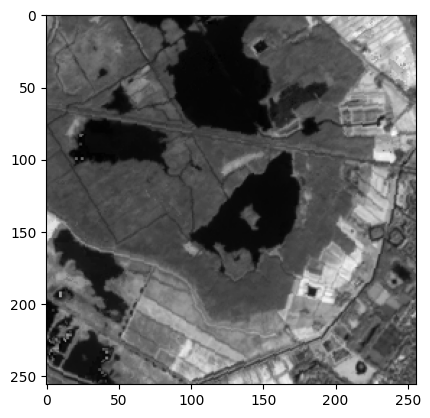

In [7]:
plt.imshow(train_dataset2[0]['image'][2,:,:],cmap='gray')

In [8]:
train_dataset = train_dataset2
valid_dataset = valid_dataset2
test_dataset = test_dataset2

n_cpu = os.cpu_count()
BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)

In [9]:
print(train_dataset[0]['image'].dtype)
print(train_dataset2[0]['image'].dtype)

print(valid_dataset[0]['image'].dtype)
print(valid_dataset2[0]['image'].dtype)

print(test_dataset[0]['image'].dtype)
print(test_dataset2[0]['image'].dtype)


uint8
uint8
uint8
uint8
uint8
uint8


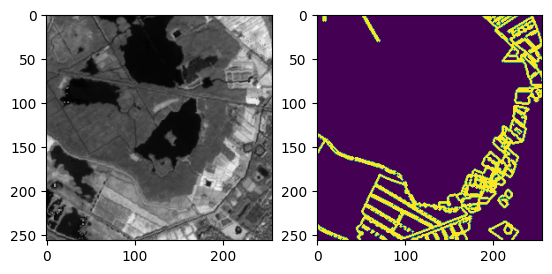

In [10]:
# lets look at some samples
sample = train_dataset[0]
plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.imshow(sample["image"][2,:,:], cmap='gray') 
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

# sample = valid_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()

# sample = test_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()

## Model

In [3]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [12]:
# Unet
# MAnet
# Linknet
# FPN
# PSPNet
# PAN
# DeepLabV3
# model = PetModel("DeepLabV3", "resnet34", in_channels=3, out_classes=1)

## Training

In [ ]:
model = PetModel("Unet", "resnet34", in_channels=3, out_classes=1)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=500,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Epoch 0:  82%|██████████████████████████▎     | 333/405 [01:08<00:14,  4.85it/s, loss=0.475, v_num=42]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████▊| 403/405 [01:14<00:00,  5.41it/s, loss=0.475, v_num=42]
Epoch 0: 100%|█| 405/405 [01:14<00:00,  5.41it/s, loss=0.475, v_num=42, valid_per_image_iou=0.336, val
Epoch 1:  82%|▊| 334/405 [01:15<00:15,  4.45it/s, loss=0.412, v_num=42, valid_per_image_iou=0.336, val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                              | 0/72 [00:00<?, ?it/s]
Epoch 1:  83%|▊| 336/405 [01:16<00:15,  4.40it/s, loss=0.412, v_num=42, valid_per_image_iou=0.336, val
Epoch 1:  83%|▊| 338/405 [01:16<00:15,  4.42it/s, loss=0.412, v_num=42, valid_per_image_iou=0.336, val
Epoch 1:  84%|▊| 340/405 [01:16<00:14,  4.44it/s, loss=0.412, v_num=42, valid_per_image_iou=0.336, val
Epoch 1:  84%|▊| 342/405 [01:16<00:14,  4.46it/s, loss=0.412, v_num=42, valid_per_image_iou=0.336, val
Epoch 1:  8

# Result visualization

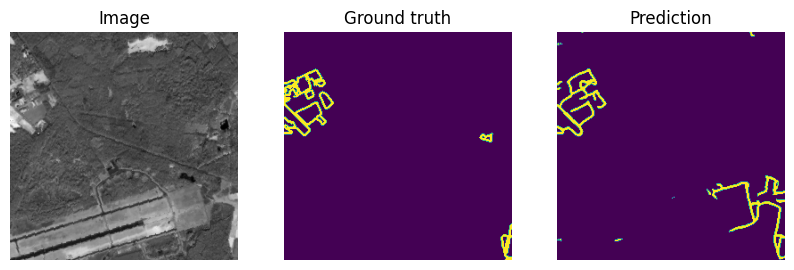

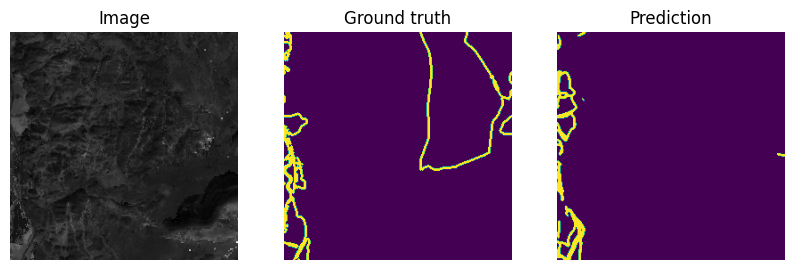

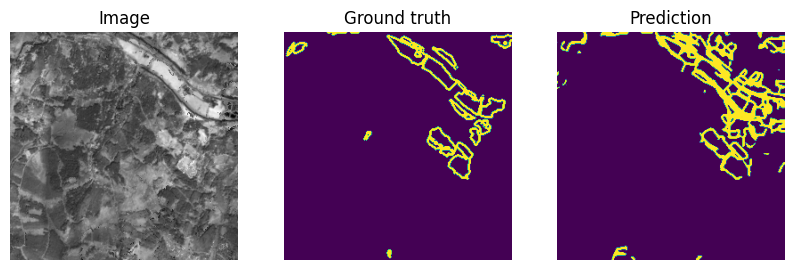

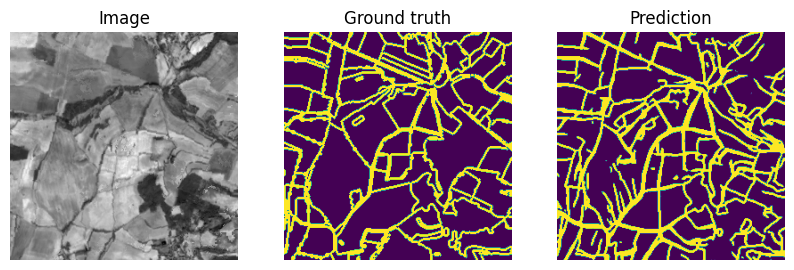

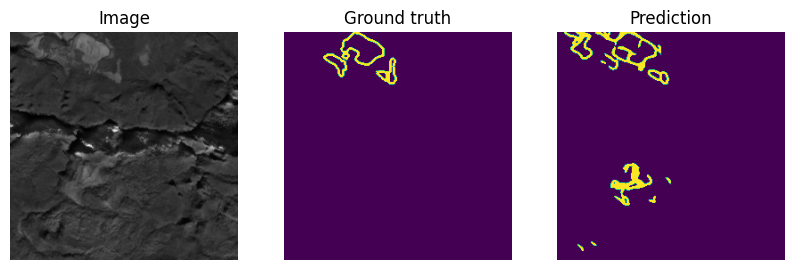

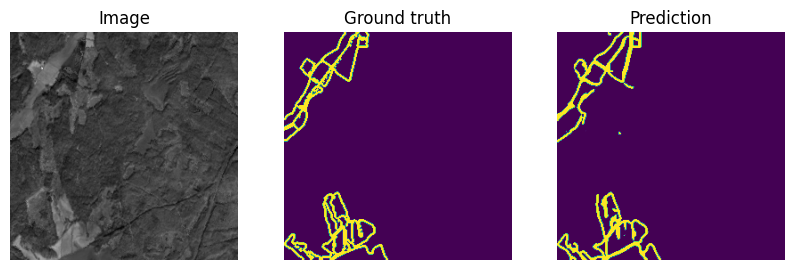

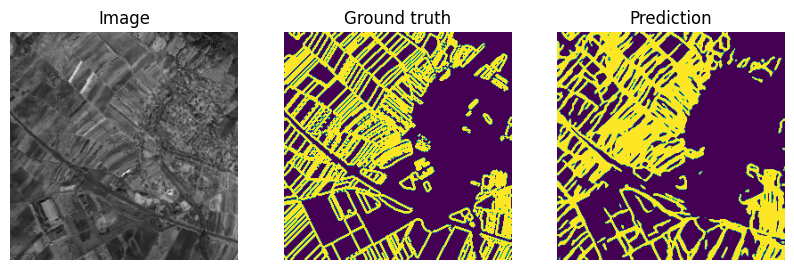

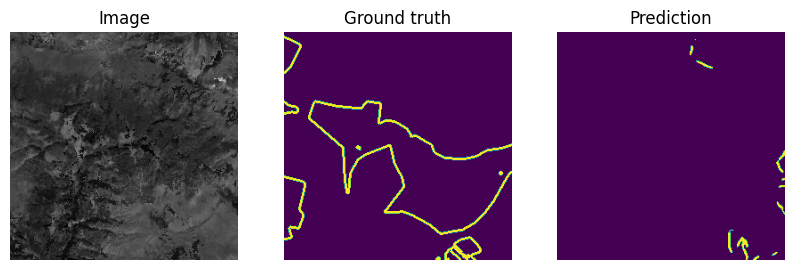

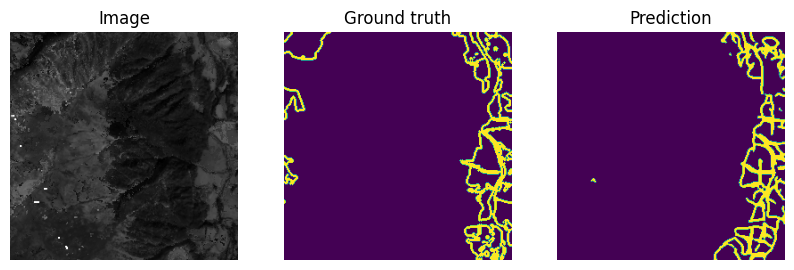

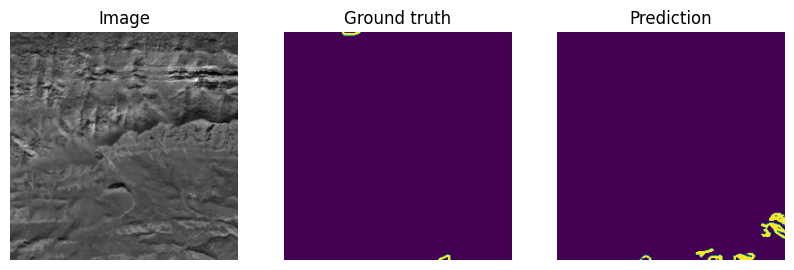

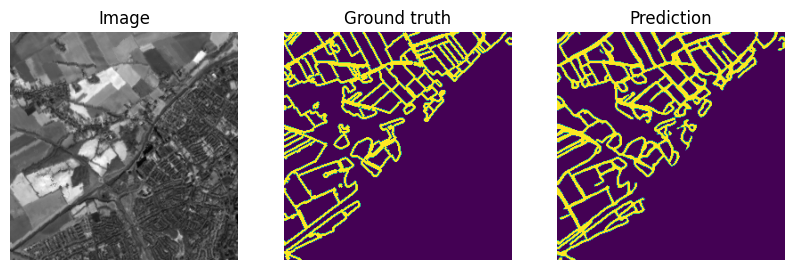

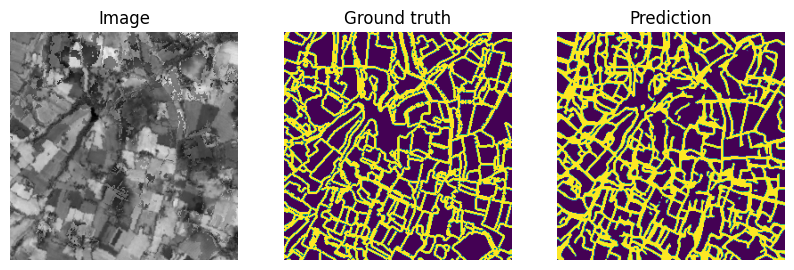

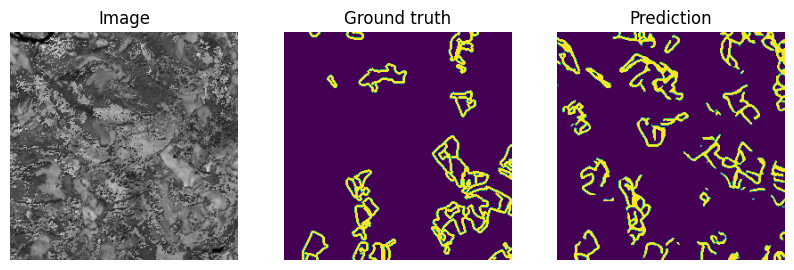

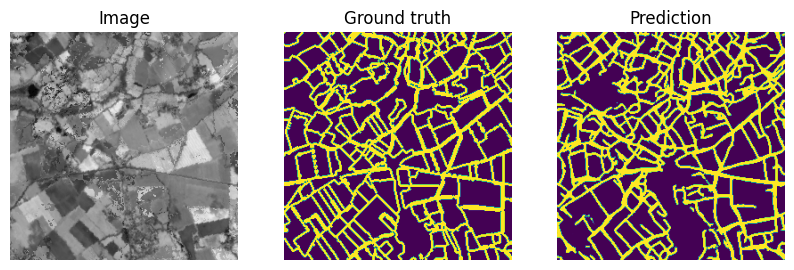

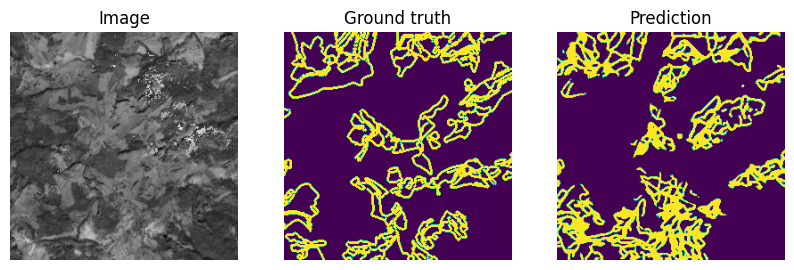

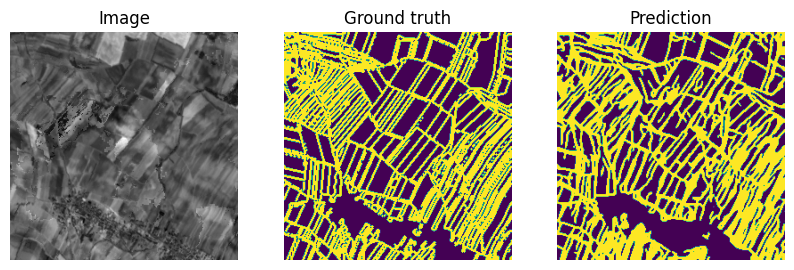

In [14]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    # plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.imshow(image.numpy()[2,:,:],cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [23]:
model = PetModel("Unet", "resnet34", in_channels=3, out_classes=1)
model_path = 'model_500epochs.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

import glob 
from osgeo import gdal
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from tqdm import tqdm
import pandas as pd
test_files = glob.glob('/home/shohei/sentinel/test/*.nc')

BATCH_SIZE = 3
BUFFER_SIZE = 1000
test_dataset2 = []

print('test image')

for i,file in tqdm(enumerate(test_files)):
    if i>BATCH_SIZE-2:
        im = plt.imread('sentinel_high.jpg')
        B3 = im[:,:,0]
        B4 = im[:,:,1]
        B8 = im[:,:,2]

        test_input = np.zeros((3,256,256))
        test_mask  = np.zeros((1,256,256))

        test_input[0,:,:] = B3
        test_input[1,:,:] = B4
        test_input[2,:,:] = B8
        
        test_dataset2.append({'image': test_input.astype(np.uint8), 'mask': test_mask.astype(np.float32)})
        break
    base_file = file.split('.nc')[0].split('test/')[1]
    data = Dataset('/home/shohei/sentinel/test/'+base_file+'.nc')
    fp = '/home/shohei/sentinel/masks/test/'+base_file+'.tif'
    img = rasterio.open(fp)
    time_slice = 0 # 0 to 5
    B2 = np.array(data['B2'][time_slice,:,:])
    B3 = np.array(data['B3'][time_slice,:,:])
    B4 = np.array(data['B4'][time_slice,:,:])
    B8 = np.array(data['B8'][time_slice,:,:])
    B2 = (255 * (B2 / B2.max() )).astype(np.int8)
    B3 = (255 * (B3 / B3.max() )).astype(np.int8)
    B4 = (255 * (B4 / B4.max() )).astype(np.int8)
    B8 = (255 * (B8 / B8.max() )).astype(np.int8)

    extent_img = img.read(1)
    boundary_img = img.read(2)
    distance_img = img.read(3)
    extent_img = extent_img.astype(np.uint8)
    boundary_img = boundary_img.astype(np.uint8)
    distance_img = distance_img.astype(np.uint8)
        
    test_input = np.zeros((3,256,256))
    test_mask  = np.zeros((1,256,256))

    # test_input[0,:,:] = B2
    test_input[0,:,:] = B3
    test_input[1,:,:] = B4
    test_input[2,:,:] = B8
    test_mask[0,:,:] = boundary_img
    # test_mask[:,:,1] = boundary_img
    # test_mask[:,:,2] = distance_img
    
    test_dataset2.append({'image': test_input.astype(np.uint8), 'mask': test_mask.astype(np.float32)})

test_dataset = test_dataset2
n_cpu = os.cpu_count()
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)

test image


2it [00:00, 100.30it/s]


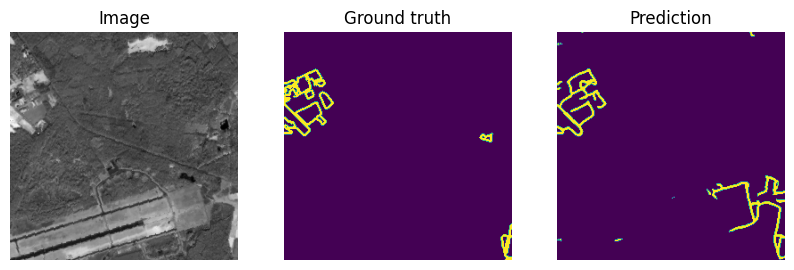

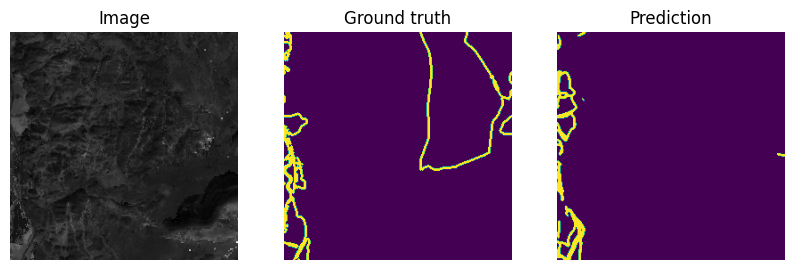

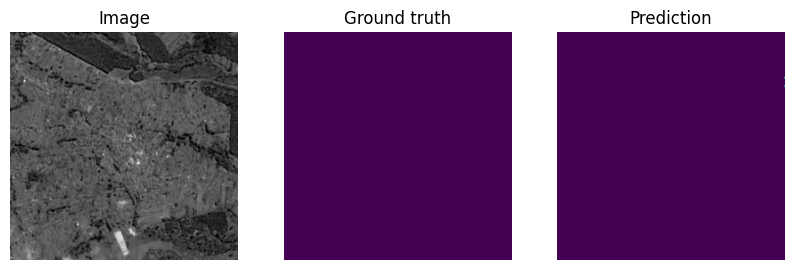

In [24]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    # plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.imshow(image.numpy()[2,:,:],cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

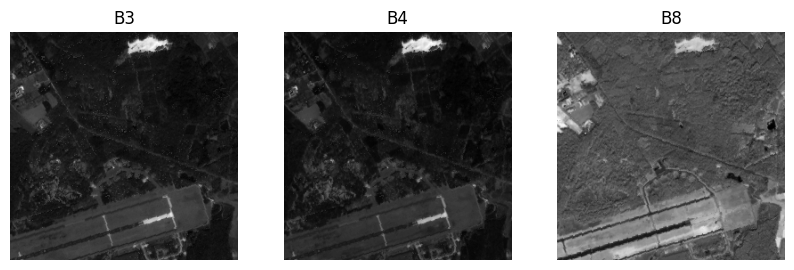

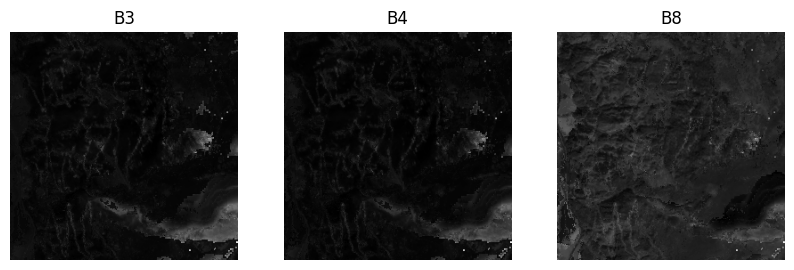

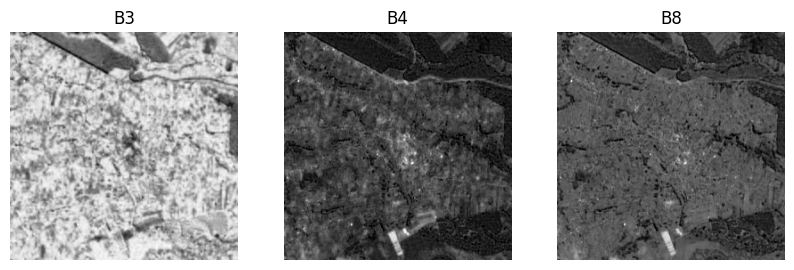

In [25]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])

for image in batch["image"]:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy()[0,:,:],cmap='gray')  # convert CHW -> HWC
    plt.title("B3")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(image.numpy()[1,:,:],cmap='gray')  # convert CHW -> HWC
    plt.title("B4")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image.numpy()[2,:,:],cmap='gray')  # convert CHW -> HWC
    plt.title("B8")
    plt.axis("off")

    plt.show()

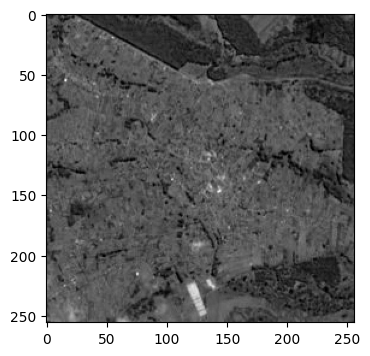

In [25]:
im = plt.imread('sentinel_high.jpg')
B3 = im[:,:,0]
B4 = im[:,:,1]
B8 = im[:,:,2]

input_image = np.zeros((3,256,256))
input_image[0,:,:] = B3
input_image[1,:,:] = B4
input_image[2,:,:] = B8

plt.figure(figsize = (4,4))
plt.imshow(B8, cmap='gray')

[[-29.566235 -41.448524 -52.21952  ... -52.63735  -42.932365 -24.45235 ]
 [-40.30513  -72.14345  -84.42994  ... -81.176994 -67.11816  -39.26249 ]
 [-31.246305 -73.58786  -88.040436 ... -93.08788  -75.35883  -46.923058]
 ...
 [-45.085827 -66.398415 -74.35118  ... -79.5186   -73.13338  -46.39741 ]
 [-40.99704  -60.07892  -69.61358  ... -81.670654 -72.58243  -45.962757]
 [-26.626324 -40.097027 -42.645042 ... -56.01589  -49.030605 -31.240679]]


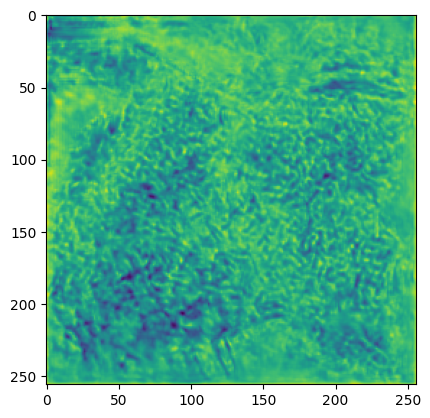

In [45]:
model.eval()  ## torch.nn.Module.eval
with torch.no_grad():  ## disable autograd
    # model(data)  # forward
    out = model(torch.tensor(input_image.astype(np.uint8)))
out = out.cpu().detach().numpy()
out = out[0,0,:,:]
print(out)
plt.imshow(out)